In [1]:
import numpy as np
import os
import pandas as pd
import time
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt

from torch.utils.data import Dataset, DataLoader
import torchvision

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
%ls ../input/task-6-data/set1_img/TestSet1

0001.jpg  0007.jpg  0013.jpg  0019.jpg  0025.jpg  0031.jpg  0037.jpg  0043.jpg
0002.jpg  0008.jpg  0014.jpg  0020.jpg  0026.jpg  0032.jpg  0038.jpg  0044.jpg
0003.jpg  0009.jpg  0015.jpg  0021.jpg  0027.jpg  0033.jpg  0039.jpg  0045.jpg
0004.jpg  0010.jpg  0016.jpg  0022.jpg  0028.jpg  0034.jpg  0040.jpg  0046.jpg
0005.jpg  0011.jpg  0017.jpg  0023.jpg  0029.jpg  0035.jpg  0041.jpg  0047.jpg
0006.jpg  0012.jpg  0018.jpg  0024.jpg  0030.jpg  0036.jpg  0042.jpg


In [4]:
%ls ../input/task-6-data/set2_img/TestSet2

0001.jpg  0007.jpg  0013.jpg  0019.jpg  0025.jpg  0031.jpg  0037.jpg  0043.jpg
0002.jpg  0008.jpg  0014.jpg  0020.jpg  0026.jpg  0032.jpg  0038.jpg  0044.jpg
0003.jpg  0009.jpg  0015.jpg  0021.jpg  0027.jpg  0033.jpg  0039.jpg  0045.jpg
0004.jpg  0010.jpg  0016.jpg  0022.jpg  0028.jpg  0034.jpg  0040.jpg  0046.jpg
0005.jpg  0011.jpg  0017.jpg  0023.jpg  0029.jpg  0035.jpg  0041.jpg  0047.jpg
0006.jpg  0012.jpg  0018.jpg  0024.jpg  0030.jpg  0036.jpg  0042.jpg  0048.jpg


In [5]:
labels1_df = pd.read_csv("../input/task-6-data/task6_set1_labels.csv")
labels2_df = pd.read_csv("../input/task-6-data/task6_set2_labels.csv")
labels1_df.head()

,image,id,label,annotator,annotation_id,created_at,updated_at,lead_time
0,/data/upload/1/2411f61b-0047.jpg,47,"[{""x"": 50.049673705844754, ""y"": 69.83964828032...",1,47,2022-05-15T01:39:40.442247Z,2022-05-15T01:39:40.442288Z,92.834
1,/data/upload/1/a2258eb8-0046.jpg,46,"[{""x"": 65.4645330510004, ""y"": 67.9771000533029...",1,46,2022-05-14T15:28:01.675342Z,2022-05-14T15:28:01.675377Z,133.534
2,/data/upload/1/67015722-0045.jpg,45,"[{""x"": 48.97368376353858, ""y"": 38.480910108785...",1,45,2022-05-14T15:25:44.910304Z,2022-05-14T15:25:44.910405Z,128.193
3,/data/upload/1/75b17b61-0044.jpg,44,"[{""x"": 65.12235323091967, ""y"": 73.611437500092...",1,44,2022-05-14T15:23:33.916678Z,2022-05-14T15:23:33.916716Z,75.206
4,/data/upload/1/eba338e8-0043.jpg,43,"[{""x"": 68.53966758255022, ""y"": 16.810418306880...",1,43,2022-05-14T15:22:16.278696Z,2022-05-14T15:22:16.278743Z,88.701


In [6]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()
new_width = 300
new_height = 300
    
file_train = []
xmin_train = []
ymin_train = []
xmax_train = []
ymax_train = []
width_train = []
height_train = []

file_test = []
xmin_test = []
ymin_test = []
xmax_test = []
ymax_test = []
width_test = []
height_test = []

for row in range(len(labels1_df)):
    f = 'set1_img/TestSet1/' + labels1_df['image'][row].split('-')[1]
    L = json.loads(labels1_df['label'][row])
    for label in L:
        xmin_train.append(label['x'] * new_width / 100.0)
        xmax_train.append((label['x'] + label['width']) * new_width / 100.0)
        ymin_train.append(label['y'] * new_height / 100.0)
        ymax_train.append((label['y'] + label['height']) * new_height / 100.0)
        width_train.append(label['original_width'])
        height_train.append(label['original_height'])
        file_train.append(f)

for row in range(len(labels2_df)):
    f = 'set2_img/TestSet2/' + labels2_df['image'][row].split('-')[1]
    L = json.loads(labels2_df['label'][row])
    if row < 28:
        for label in L:
            xmin_train.append(label['x'] * new_width / 100.0)
            xmax_train.append((label['x'] + label['width']) * new_width / 100.0)
            ymin_train.append(label['y'] * new_height / 100.0)
            ymax_train.append((label['y'] + label['height']) * new_height / 100.0)
            width_train.append(label['original_width'])
            height_train.append(label['original_height'])
            file_train.append(f)

    else:
        for label in L:
            xmin_test.append(label['x'] * new_width / 100.0)
            xmax_test.append((label['x'] + label['width']) * new_width / 100.0)
            ymin_test.append(label['y'] * new_height / 100.0)
            ymax_test.append((label['y'] + label['height']) * new_height / 100.0)
            width_test.append(label['original_width'])
            height_test.append(label['original_height'])
            file_test.append(f)
        
train_df['file'] = file_train
train_df['xmin'] = xmin_train
train_df['xmax'] = xmax_train
train_df['ymin'] = ymin_train
train_df['ymax'] = ymax_train
train_df['width'] = width_train
train_df['height'] = height_train

test_df['file'] = file_test
test_df['xmin'] = xmin_test
test_df['xmax'] = xmax_test
test_df['ymin'] = ymin_test
test_df['ymax'] = ymax_test
test_df['width'] = width_test
test_df['height'] = height_test

train_df.head()

,file,xmin,xmax,ymin,ymax,width,height
0,set1_img/TestSet1/0047.jpg,150.149021,160.083762,209.518945,215.532372,2000,3552
1,set1_img/TestSet1/0047.jpg,197.587410,207.522151,208.260321,214.273748,2000,3552
2,set1_img/TestSet1/0047.jpg,150.894127,161.325605,237.488374,243.921342,2000,3552
3,set1_img/TestSet1/0046.jpg,196.393599,206.040972,203.931300,209.710108,2000,3552
4,set1_img/TestSet1/0046.jpg,239.498881,248.735727,202.544386,207.976466,2000,3552


In [7]:
def get_file_boxes(data_df, file):
    """
    Функция, которая по названию файла выдает лейбл и координаты боксов.
    Аргументы:

      data -- датафрейм с данными;
      file -- название файла.
    Возвращает:
      boxes -- координаты босков 
      в формате xmin, ymin, xmax, ymax.
    """
    part_data = data_df.where(data_df['file'] == file).dropna(how='any', axis=0)
    boxes = part_data[["xmin", "ymin", "xmax", "ymax"]].values
    return boxes

In [8]:
print(get_file_boxes(train_df, 'set2_img/TestSet2/0022.jpg'))

[[101.2280729  163.02890474 109.21933381 176.23471754]
 [129.1273873  178.97554661 136.27746285 191.93219314]
 [119.59395323 228.06130363 127.0244239  240.51961759]]


In [9]:
def plot_boxes(boxes, ax, edgecolor='green'):
    """
    Функция отрисовки box-ов.
    Аргументы:
      boxes -- массив боксов, которые задаются координатами
      xmin, ymin, xmax, ymax;
      ax -- полотно, на котором отрображена исходная картинка.
    """
    
    box_kwargs = dict(linewidth=2, fill=False, edgecolor=edgecolor, 
                      facecolor='none')
    for i, box in enumerate(boxes):

        left_x, top_y, right_x, bottom_y = box
        width = right_x - left_x + 1
        height = bottom_y - top_y + 1

        box_patch = Rectangle((left_x, top_y), width=width, height=height, 
                              **box_kwargs)
        ax.add_patch(box_patch)

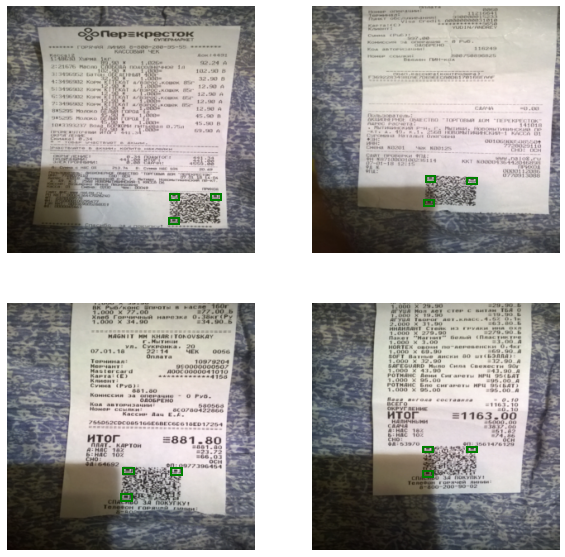

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
input_size = (300, 300)

i = 0
for dp, dn, files in os.walk("../input/task-6-data/"):
    for file in files:
        if file[-4:].lower() != '.jpg':
            continue
        if int(file.split('/')[-1].split('.')[0]) < 30:
            continue
        img = Image.open(os.path.join(dp, file))
        img = transforms.Resize(input_size)(img)
        splitted_dp = dp.split('/')
        file_str = splitted_dp[3] + '/' + splitted_dp[4]+ '/' + file
        boxes = get_file_boxes(train_df, file_str)
        ax = axes[i // 2, i % 2]
        ax.imshow(img)
        plot_boxes(boxes, ax)
        ax.axis("off")
        i += 1
        if i >= 4:
            break
    if i >= 4:
        break
plt.show()

In [11]:
train_df.to_csv('../working/train_df.csv')
test_df.to_csv('../working/test_df.csv')

In [12]:
class QRDataset(Dataset):
    def __init__(self, images_path, df, input_size = (300, 300)):
        self.transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean = [0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        self.df = df
        self.images_path = images_path

    def __len__(self,):
        return len(self.df)

    def __getitem__(self, idx):
        file = self.df['file'][idx]
        img = Image.open(os.path.join(self.images_path, file))
        img = self.transform(img)
        boxes = get_file_boxes(self.df, file)
        return img, torch.tensor(boxes) / 300

In [13]:
def collate_fn(batch):
    images = []
    boxes = []
    for b in batch:
        images.append(b[0])
        boxes.append(b[1])
    images = torch.stack(images)
    return images, boxes

In [14]:
train_batch_size = 16
train_dataset = QRDataset(images_path="../input/task-6-data/", df = train_df)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, 
                    shuffle=True, pin_memory=True, collate_fn=collate_fn)

In [15]:
test_dataset = QRDataset(images_path="../input/task-6-data/", df = test_df)

In [16]:
# Клорируем репозиторий
! git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection.git

# Компируем все из папки a-PyTorch-Tutorial-to-Object-Detection в текущую папку
! cp a-PyTorch-Tutorial-to-Object-Detection/* . -R -n -v

# Удаляем ненужные папки
! rm -r "a-PyTorch-Tutorial-to-Object-Detection"
! rm -r img

Cloning into 'a-PyTorch-Tutorial-to-Object-Detection'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 249 (delta 59), reused 55 (delta 55), pack-reused 181
Receiving objects: 100% (249/249), 175.95 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (117/117), done.
'a-PyTorch-Tutorial-to-Object-Detection/LICENSE' -> './LICENSE'
'a-PyTorch-Tutorial-to-Object-Detection/README.md' -> './README.md'
'a-PyTorch-Tutorial-to-Object-Detection/create_data_lists.py' -> './create_data_lists.py'
'a-PyTorch-Tutorial-to-Object-Detection/datasets.py' -> './datasets.py'
'a-PyTorch-Tutorial-to-Object-Detection/detect.py' -> './detect.py'
'a-PyTorch-Tutorial-to-Object-Detection/eval.py' -> './eval.py'
'a-PyTorch-Tutorial-to-Object-Detection/img' -> './img'
'a-PyTorch-Tutorial-to-Object-Detection/img/000001.jpg' -> './img/000001.jpg'
'a-PyTorch-Tutorial-to-Object-Detection/img/000022.jpg' -> './img/000022.

In [17]:
class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        As in the paper, use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        opy these parameters into network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. See 'decimate' in utils.py.
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")


class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary/additional convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):
        """
        Forward propagation.
        :param conv7_feats: lower-level conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats


class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.
    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 prior (default) boxes.
    See 'cxcy_to_gcxgcy' in utils.py for the encoding definition.
    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self):
        super(PredictionConvolutions, self).__init__()
        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        # 4 prior-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)
        
        # Convolutions for prediction
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'], kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'], kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'], kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'], kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'], kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'], kernel_size=3, padding=1)

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.
        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and scores for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1, 1)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1, 1)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, 1)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, 1)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, 1)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, 1)  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, 
                          l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, 
                            c_conv10_2, c_conv11_2], dim=1)  # (N, 8732, n_classes)

        return locs, scores


class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base VGG network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions()

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()

    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base(image)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = \
            self.aux_convs(conv7_feats)  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, 
                                       conv9_2_feats, conv10_2_feats, conv11_2_feats)  # (N, 8732, 4), (N, 8732, n_classes)

        return locs, scores

    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.
        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append(
                            [cx, cy, obj_scales[fmap] * sqrt(ratio), 
                             obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(
                                    obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes

    def detect_objects(self, predicted_locs, scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.
        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        
        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_scores = list()

            # Keep only predicted boxes and scores where scores for this class are above the minimum score
            score_above_min_score = scores > min_score  # torch.uint8 (byte) tensor, for indexing
            n_above_min_score = score_above_min_score.sum().item()
            if n_above_min_score == 0:
                continue
            scores = scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
            decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

            # Sort predicted boxes and scores by scores
            scores, sort_ind = scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
            decoded_locs = decoded_locs[sort_ind]  # (n_min_score, 4)

            # Find the overlap between predicted boxes
            overlap = find_jaccard_overlap(decoded_locs, decoded_locs)  # (n_qualified, n_min_score)

                
            # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
            # 1 implies suppress, 0 implies don't suppress
            suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

            # Consider each box in order of decreasing scores
            for box in range(decoded_locs.size(0)):
                # If this box is already marked for suppression
                if suppress[box] == 1:
                    continue

                # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                # Find such boxes and update suppress indices
                suppress = torch.max(suppress, overlap[box] > max_overlap)
                # The max operation retains previously suppressed boxes, like an 'OR' operation

                # Don't suppress this box, even though it has an overlap of 1 with itself
                suppress[box] = 0

            # Store only unsuppressed boxes for this class
            image_boxes.append(decoded_locs[1 - suppress])
            image_scores.append(scores[1 - suppress])

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                
            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_scores  # lists of length batch_size


class BoxLoss(nn.Module):
    
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(BoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, locs, scores, boxes):
        """
        Forward propagation.
        :param locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :return: loss, a scalar
        """
        batch_size = locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        
        assert n_priors == locs.size(1) == scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        
        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        
        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(locs, true_locs)  # (), scalar

        return loc_loss

In [18]:
from utils import *

In [19]:
def train(train_loader, model, criterion, optimizer, 
          history, epoch, n_epochs, device, print_freq=50):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        labels = [0] * train_batch_size
        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        history['loss'].append(loss)
        optimizer.step()
        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)
        start = time.time()

        # Print status
        if i % print_freq == 0:
            print(f'Epoch: {epoch}/{n_epochs}\t'
                  f'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  f'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  f'Loss {losses.val:.4f} ({losses.avg:.4f})\t')
            
    del predicted_locs, predicted_scores, images, boxes  # free some memory since their histories may be stored

In [20]:
def save_checkpoint(state_path, epoch, model, optimizer, history,):
    """
    Сохраняется чек-поинт модели.

    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer,
             'history': history,
    }
    torch.save(state, state_path)

In [21]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
n_classes = 1

In [23]:
def trainer(train_dataloader,
            device="cpu",
            start_epoch=0, n_epochs=300,
            lr=1e-3, momentum=0.9, weight_decay=5e-4,
            state_path="../working/checkpoint_ssd300.pth",
            ):

    # Initialize model or load checkpoint

    if not os.path.exists(state_path):
        start_epoch = 0
        model = SSD300(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(
            params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
            lr=lr, momentum=momentum, weight_decay=weight_decay)
        history = {'loss': []}

    else:
        checkpoint = torch.load(state_path)
        start_epoch = checkpoint['epoch'] + 1
        print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']
        history = checkpoint['history']

    # Move to default device
    model = model.to(device)
    criterion = BoxLoss(priors_cxcy=model.priors_cxcy).to(device)
    # Epochs
    for epoch in range(start_epoch, n_epochs):

        # One epoch's training
        train(train_loader=train_dataloader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              history=history,
              epoch=epoch,
              n_epochs=n_epochs,
              device=device,
        )

        # Save checkpoint
        save_checkpoint(state_path, epoch, model, optimizer, history)

In [24]:
trainer(train_dataloader, device = device, n_epochs = 200)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]


Loaded base model.



/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch: 0/200	Batch Time 10.050 (10.050)	Data Time 4.334 (4.334)	Loss 15.6084 (15.6084)	
Epoch: 1/200	Batch Time 3.236 (3.236)	Data Time 2.776 (2.776)	Loss 14.9031 (14.9031)	
Epoch: 2/200	Batch Time 3.238 (3.238)	Data Time 2.780 (2.780)	Loss 13.5899 (13.5899)	
Epoch: 3/200	Batch Time 3.428 (3.428)	Data Time 2.974 (2.974)	Loss 12.4355 (12.4355)	
Epoch: 4/200	Batch Time 3.222 (3.222)	Data Time 2.759 (2.759)	Loss 12.1975 (12.1975)	
Epoch: 5/200	Batch Time 3.240 (3.240)	Data Time 2.782 (2.782)	Loss 11.1284 (11.1284)	
Epoch: 6/200	Batch Time 3.240 (3.240)	Data Time 2.788 (2.788)	Loss 10.6909 (10.6909)	
Epoch: 7/200	Batch Time 3.232 (3.232)	Data Time 2.772 (2.772)	Loss 10.3552 (10.3552)	
Epoch: 8/200	Batch Time 3.969 (3.969)	Data Time 3.511 (3.511)	Loss 9.9124 (9.9124)	
Epoch: 9/200	Batch Time 3.202 (3.202)	Data Time 2.758 (2.758)	Loss 9.2357 (9.2357)	
Epoch: 10/200	Batch Time 3.390 (3.390)	Data Time 2.941 (2.941)	Loss 9.2580 (9.2580)	
Epoch: 11/200	Batch Time 3.488 (3.488)	Data Time 3.044 (3

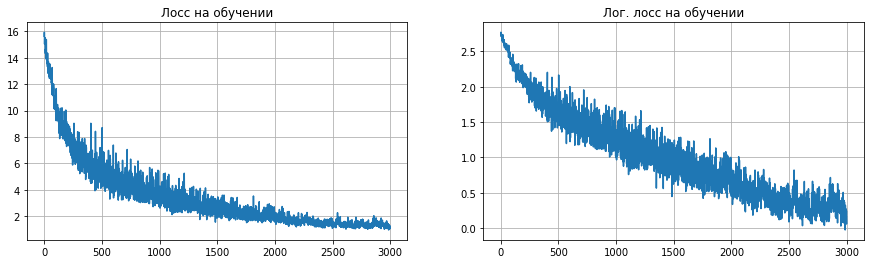

In [25]:
state = torch.load('../working/checkpoint_ssd300.pth')
loss = state['history']['loss']
loss_cpu = np.array([t.cpu().detach().numpy() for t in loss])
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_cpu)
plt.title("Лосс на обучении")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.log(loss_cpu))
plt.title("Лог. лосс на обучении")
plt.grid()
plt.show()